## Predictive Modeling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import sys
import os
import pandas as pd

In [23]:
# Add src to path to import utils
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import load_data, clean_data, get_summary_statistics

# Load the data
data_path = '../data/MachineLearningRating_v3.txt'
df = load_data(data_path)

if df is not None:
    print("Data loaded successfully!")
    print(f"Shape of the dataset: {df.shape}")

c:\Users\Abel Tesfa\Desktop\alphainsurancefinal\src\utils.py:8: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='|', encoding='utf-8')


Data loaded successfully!
Shape of the dataset: (1000098, 52)


In [27]:
import numpy as np
# Filter policies with claims > 0
df_claims = df[df["TotalClaims"] > 0].copy()

# Numeric features (only columns that exist)
numeric_features = [
    'TotalPremium', 'CustomValueEstimate', 'Cylinders', 'cubiccapacity', 'kilowatts', 
    'NumberOfDoors', 'CapitalOutstanding', 'SumInsured', 'NumberOfVehiclesInFleet', 'RegistrationYear'
]
numeric_features_existing = [col for col in numeric_features if col in df_claims.columns]

# Convert numeric columns to numeric dtype (coerce errors to NaN)
for col in numeric_features_existing:
    df_claims[col] = pd.to_numeric(df_claims[col], errors='coerce')

# Drop columns that are all NaN after coercion
df_claims.dropna(axis=1, how='all', inplace=True)

# Update the list of existing numeric features
numeric_features_existing = [col for col in numeric_features_existing if col in df_claims.columns]

# Impute missing numeric values
num_imputer = SimpleImputer(strategy='mean')
imputed_data = num_imputer.fit_transform(df_claims[numeric_features_existing])
df_claims[numeric_features_existing] = pd.DataFrame(imputed_data, index=df_claims.index, columns=numeric_features_existing)


# Categorical features (only columns that exist)
categorical_features = [
    'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 
    'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone',
    'ItemType', 'mmcode', 'VehicleType', 'make', 'Model', 'bodytype', 'NewVehicle', 'WrittenOff',
    'Rebuilt', 'Converted', 'CrossBorder', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 
    'Product', 'StatutoryClass', 'StatutoryRiskType', 'ExcessSelected'
]
categorical_features_existing = [col for col in categorical_features if col in df_claims.columns]

# Encode categorical features
df_encoded = pd.get_dummies(df_claims, columns=categorical_features_existing, drop_first=True)

# Target variable
target = 'TotalClaims'

# Define features for the model
# Combine original numeric features with the new dummy variables
dummy_cols = [col for col in df_encoded.columns if any(cat_col in col for cat_col in categorical_features_existing)]
final_features = numeric_features_existing + dummy_cols

# Split features and target
X = df_encoded[final_features]
y = df_claims[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure data is in a SHAP-compatible format (numeric)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


print("Data prepared successfully!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Data prepared successfully!
X_train shape: (1951, 871), y_train shape: (1951,)


In [28]:
# Train the Model
# %%
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}, R2: {r2_score(y_test, y_pred_lr):.2f}")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}, R2: {r2_score(y_test, y_pred_rf):.2f}")

# XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}, R2: {r2_score(y_test, y_pred_xgb):.2f}")

Linear Regression RMSE: 36636.69, R2: 0.15
Random Forest RMSE: 35960.97, R2: 0.18
Random Forest RMSE: 35960.97, R2: 0.18
XGBoost RMSE: 38330.81, R2: 0.07
XGBoost RMSE: 38330.81, R2: 0.07


 98%|===================| 818/837 [00:39<00:00]        

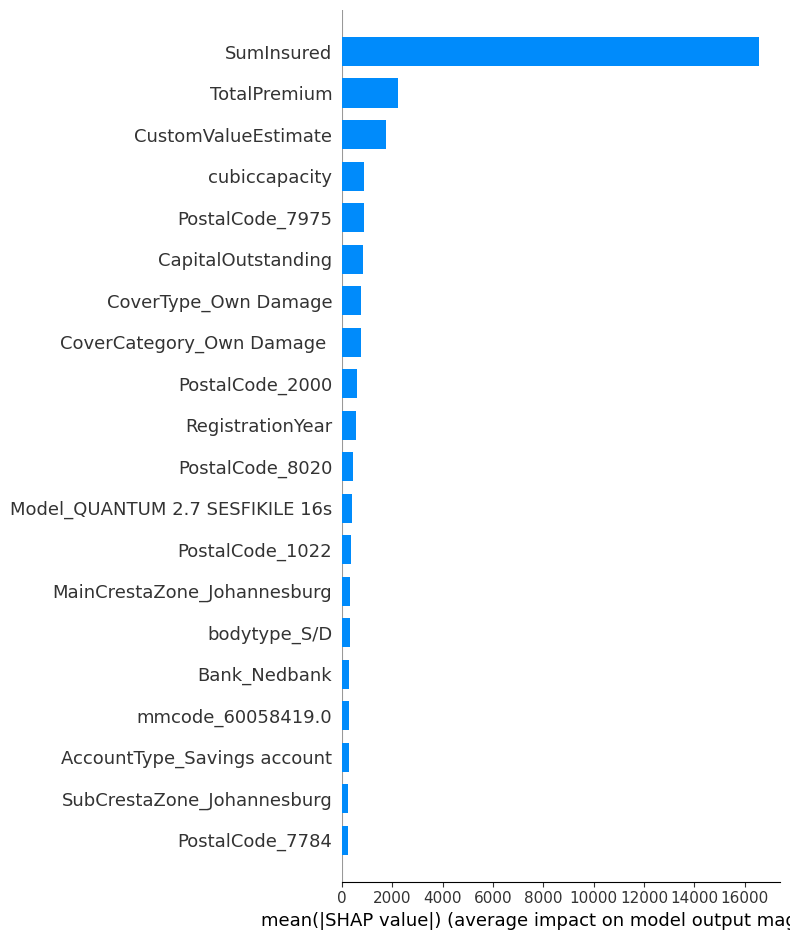

In [29]:
# %%
import shap

# Use Random Forest for SHAP explanation
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# Summary plot of top features
shap.summary_plot(shap_values, X_test, plot_type="bar")